In [0]:
# README: Run in Google Colab...

In [0]:
# Imports
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import string
import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [0]:
# Data Loading
url = '/content/drive/My Drive/Colab Notebooks/US_trending.pkl'
videos_df = pd.read_pickle(url)
videos_df.head()

,video_id,title,published_at,channel_id,channel_title,category_id,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,days_in_trending,category_name,publish_to_trend,publishing_hour,publishing_day,positive_sentiment,negative_sentiment,neutral_sentiment,analyzed_comments
0,vPx6M7eTYbc,Spill Your Guts: Harry Styles & Kendall Jenner,2019-12-11 07:08:34,UCJ0uqCI0Vqr2Rrt1HseGirg,The Late Late Show with James Corden,24,2019-12-12,The Late Late Show|Late Late Show|James Corden...,11636632,571835,8256,20068,https://i.ytimg.com/vi/vPx6M7eTYbc/default.jpg,False,False,Late Late Show guest host Harry Styles challen...,1,Entertainment,1,7,Wednesday,0.468750,0.131250,0.400000,160.0
1,sg8WaeeFyNY,WE GOT UNEXPECTED NEWS..,2019-12-12 05:25:42,UCDSJCBYqL7VQrlXfhr1RtwA,Les Do Makeup,26,2019-12-12,[none],423215,52780,773,13130,https://i.ytimg.com/vi/sg8WaeeFyNY/default.jpg,False,False,Hi babygirls! Thank you so much for watching ...,7,How-to & Style,0,5,Thursday,0.750000,0.075000,0.175000,40.0
2,q1PR05q8l2g,"Last To Miss Layup Wins $10,000",2019-12-11 23:00:53,UCQIUhhcmXsu6cN6n3y9-Pww,Jesser,17,2019-12-12,last to leave|nba basketball|nba basketball hi...,463685,20178,586,931,https://i.ytimg.com/vi/q1PR05q8l2g/default.jpg,False,False,"Last to miss the basketball shot wins 10,000!●...",7,Sport,1,23,Wednesday,0.318182,0.181818,0.500000,88.0
3,t6Z6RIXq0L0,LAKERS at MAGIC | FULL GAME HIGHLIGHTS | Decem...,2019-12-12 02:35:33,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,17,2019-12-12,sp:ty=high|sp:dt=2019-12-12T00:00:00Z|sp:st=ba...,659579,4605,288,668,https://i.ytimg.com/vi/t6Z6RIXq0L0/default.jpg,False,False,LAKERS at MAGIC | FULL GAME HIGHLIGHTS | Decem...,2,Sport,0,2,Thursday,0.462069,0.193103,0.344828,145.0
4,TGDpRB4ovvA,TIPPING DRIVE-THRU WORKERS $100 FOR THE HOLIDA...,2019-12-12 02:38:37,UCtj45MepAoKxZoyR_Mnt86Q,Royal Family,24,2019-12-12,queen Naija|Medicine|Queen|Spicy|Royalty Squad...,175558,18400,164,1907,https://i.ytimg.com/vi/TGDpRB4ovvA/default.jpg,False,False,LAST VIDEO ; https://youtu.be/okujHUu_hmQ*MAKE...,6,Entertainment,0,2,Thursday,0.631250,0.131250,0.237500,160.0


In [0]:
# Data Preprocessing
videos_df.dropna(inplace=True, subset=['description'])

def filter_stopwords(text):
    text = text.lower()
    word_list = nltk.word_tokenize(text)
    filtered_words = [word for word in word_list if word not in STOPWORDS]
    return ' '.join(filtered_words)

# Make X (video titles) and y (video categories) vectors
video_descriptions = videos_df['description'].apply(lambda var: filter_stopwords(var))

category_dummies = pd.get_dummies(videos_df['category_name'])
categories = list(category_dummies.columns)
labels = category_dummies.values
print('Shape of label tensor:', labels.shape)
categories_num = labels.shape[1]

for i in range(0, 10):
    print(video_descriptions[i])

Shape of label tensor: (3510, 15)
late late show guest host harry styles challenges kendall jenner game spill guts fill guts , two ask personal questions face choice : answer truthfully eat whatever front . cod sperm salmon smoothie force spill guts ? late late show : subscribe : http : //bit.ly/cordenyoutubewatch full episodes : http : //bit.ly/1enypw4facebook : http : //on.fb.me/19pihlctwitter : http : //bit.ly/1iv0q6kinstagram : http : //bit.ly/latelategramwatch late late show james corden weeknights 12:35 et/11:35 pm ct. cbs.get new episodes shows love across devices next day , stream live tv , watch full seasons cbs fan favorites anytime , anywhere cbs access . try free ! http : //bit.ly/1oqa29b -- -each week night , late late show james corden throws ultimate late night party mix celebrity guests , edgy musical acts , games sketches . corden differentiates show offering viewers peek behind-the-scenes green room , bringing guests lending musical acting talents various sketches . a

In [0]:
# Word2Vec Model (pretrained on Google News dataset)
word2vec_path = '/content/drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin'
w2v_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

w2v_weights = w2v_model.vectors
vocab_len, embedding_size = w2v_weights.shape

# model test
#w2v_model.most_similar(positive=['woman', 'king'], negative=['man'])

#w2v_model = gensim.models.Word2Vec(video_descriptions, size=100, window=5, min_count=3, workers=4)

def word2token(word):
    try:
        return w2v_model.vocab[word].index
    except KeyError:
        return 0
    
def token2word(token):
    return w2v_model.index2word[token]

# test
token = word2token('news')
word = token2word(token)
print(word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


news


In [0]:
# Preparing data as sequences for LSTM
# Hyperparameters
vocab_size = 8000
embedding_dim = 128
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [0]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(video_descriptions, labels, test_size=0.15, random_state=33)
print('X_train length: {}'.format(len(X_train)))
print('y_train length: {}'.format(len(y_train)))
print('X_test length: {}'.format(len(X_test)))
print('y_test length: {}'.format(len(y_test)))

X_train length: 2983
y_train length: 2983
X_test length: 527
y_test length: 527


In [0]:
#
# Find vocab_size (5000) most common words, and replace all other words with oov_tok (<OOV>)
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

# Turn tokens into list of sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[10])

lengths = []
for seq in train_sequences:
    lengths.append(len(seq))

print('Maximum length of sequences: {}'.format(max(lengths)))

# Padding - make sequences of same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

[1, 1, 367, 110, 95, 23, 595, 367, 202, 1247, 2605, 203, 375, 35, 3465, 1127, 556, 24, 49, 22, 3, 3466, 146, 3467, 19, 110, 24, 22, 5, 10, 9, 3937, 87, 66, 304, 1555, 8, 22, 3, 8, 2, 2961, 22, 3, 4, 6, 2, 2962, 12, 22, 3, 4, 12, 2, 2963, 98, 22, 2964, 123, 72, 45, 286, 119, 2965, 523, 1052, 1632, 53]
Maximum length of sequences: 718
240
300
123
300
68
300


In [0]:
#
# Same job for test (validation) set
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(test_padded.shape)

(527, 300)


In [0]:
# LSTM building
def create_model_RNN():
    model = Sequential()
    # Keras Embedding layer with Word2Vec weights initialization
    model.add(Embedding(input_dim=vocab_len,
                        output_dim=embedding_size,
                        weights=[w2v_weights],
                        input_length=max_length,
                        mask_zero=True,
                        trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.2))
    model.add(Dense(categories_num, activation='softmax'))
    print(model.summary())
    return model

model = create_model_RNN()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 300)          900000000 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 300, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 15)                3855      
Total params: 900,443,151
Trainable params: 443,151
Non-trainable params: 900,000,000
_________________________________________________________________
None


In [0]:
# LSTM Training
#with tf.device('/gpu:0'):
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit(train_padded, y_train, epochs=15, batch_size=64, validation_data=(test_padded, y_test), verbose=1)
history = model.fit(train_padded, y_train, epochs=30, batch_size=64, validation_split=0.1, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 2684 samples, validate on 299 samples
Epoch 1/30
2684/2684 [==============================] - 58s 22ms/sample - loss: 2.2467 - acc: 0.2999 - val_loss: 2.0932 - val_acc: 0.2542
Epoch 2/30
2684/2684 [==============================] - 56s 21ms/sample - loss: 1.9058 - acc: 0.3927 - val_loss: 1.8025 - val_acc: 0.4181
Epoch 3/30
2684/2684 [==============================] - 56s 21ms/sample - loss: 1.6162 - acc: 0.5034 - val_loss: 1.5450 - val_acc: 0.5385
Epoch 4/30
2684/2684 [==============================] - 56s 21ms/sample - loss: 1.3466 - acc: 0.5999 - val_loss: 1.3519 - val_acc: 0.6020
Epoch 5/30
2684/2684 [==============================] - 56s 21ms/sample - loss: 1.1428 - acc: 0.6639 - val_loss: 1.2220 - val_acc: 0.6355
Epoch 6/30
2684/2684 [==============================] - 55s 21ms/sample - loss: 0.9957 - acc: 0.7001 - val_loss: 1.1165 - val_acc: 0.6689
Epoch 7/30
2684/2684 [==============================] - 55s 21ms/sample - loss: 0.9016 - acc: 0.7317 - val_loss: 1.0712 - val

In [0]:
accr = model.evaluate(test_padded, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

527/527 [==============================] - 3s 6ms/sample - loss: 0.8910 - acc: 0.7742
Test set
  Loss: 0.891
  Accuracy: 0.774


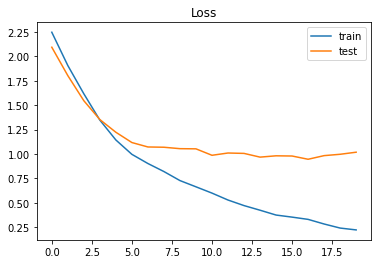

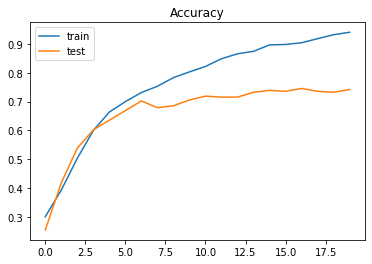

In [0]:
# Visualization
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();